In [46]:
#Importing the Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,classification_report,roc_auc_score,precision_score,recall_score
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading the dataset
df=pd.read_csv(r"/content/drive/MyDrive/Fraud.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Data Visualisation

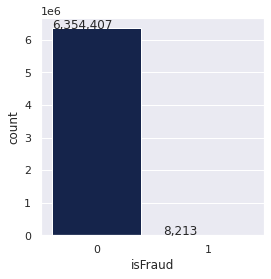

In [7]:
## Visualizing isFraud Column

plt.figure(figsize=(4,4))
df['isFraud'].value_counts()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="isFraud", data=df,color = "#0c2054" )
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')),
            (p.get_x(), p.get_height()))

In [8]:
df['isFraud'].value_counts(normalize=True) * 100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

isFraud Column shows that the classes are imbalanced.
Only 0.13% (8,213) transactions in the dataset are fraudulent indicating high-class 
imbalance in the dataset. This is important because if we build a machine learning model 
on this highly skewed data, the non-fraudulent transactions will influence the training of 
the model almost entirely, thus affecting the results.

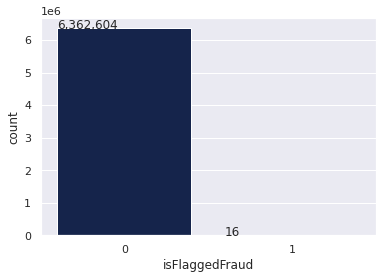

In [9]:
# Visualizing isFlaggedFraud column
df['isFlaggedFraud'].value_counts()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="isFlaggedFraud", data=df,color = "#0c2054")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

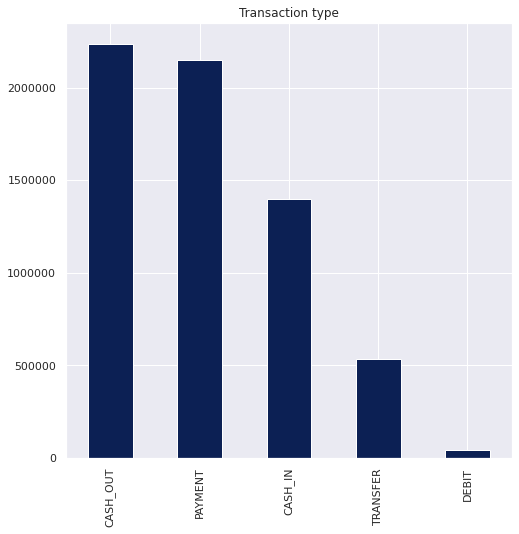

In [10]:
#Visualizing Type column
f, ax = plt.subplots(1, 1, figsize=(4, 4))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8),color = "#0c2054")
plt.ticklabel_format(style='plain', axis='y')

In [11]:
pd.crosstab(df['type'], df['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


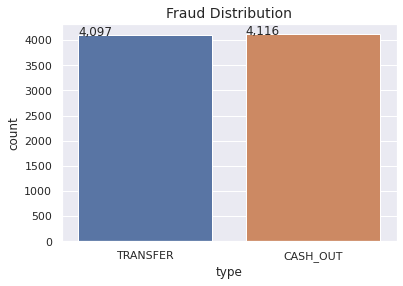

In [12]:
#Visualizing distrubution of fraud transactions

ax=sns.countplot('type', data=df[(df['isFraud'] == 1)])
plt.title('Fraud Distribution', fontsize=14)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

plt.show()

We find that of the five types of transactions, fraud occurs only in two of them 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs .

Since only CASH-OUT and TRANSFER transactions can be fraudulent, we reduce the 
size of the dataset by retaining only these transaction types and removing PAYMENT, CASH-IN and DEBIT.

In [13]:
df= df.loc[df['type'].isin(['CASH_OUT','TRANSFER']),:]
df.shape

(2770409, 11)

In [14]:
#Extracting the time of transaction from Step Column

fraud = df[df["isFraud"] == 1]
Notfraud = df[df["isFraud"] == 0]

Notfraud['transactionHour'] = Notfraud['step'] % 24
fraud['transactionHour'] = fraud['step'] % 24

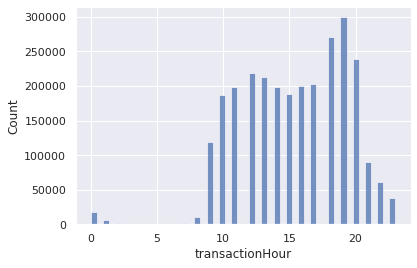

In [15]:
#Distribution of not fraud
sns.histplot(data = Notfraud
            ,x = 'transactionHour'
            ,bins=50
            );

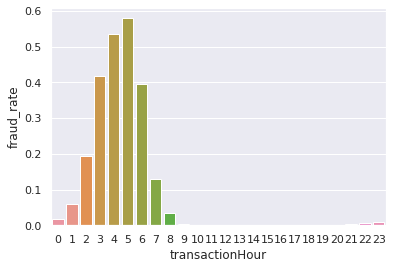

In [16]:
# Distribution of fraud
df['transactionHour'] = df['step'] % 24
frauds_hour = pd.concat([df.groupby("transactionHour")["isFraud"].sum(),df.groupby("transactionHour")["isFraud"].count()],axis=1)
frauds_hour.columns = ["Frauds","Transactions"]
frauds_hour["fraud_rate"] = frauds_hour.Frauds/frauds_hour.Transactions
sns.barplot(x=frauds_hour.index,y=frauds_hour.fraud_rate)
plt.show()

From the above distribution plot, it can be interpreted that frauds happen during sleeping hours the most. Close to 20% of transactions that happen during 4 AM and 5 AM are fraud transactions.



In [17]:
# converting into object type
df['transactionHour'] = df['transactionHour'].astype('int')

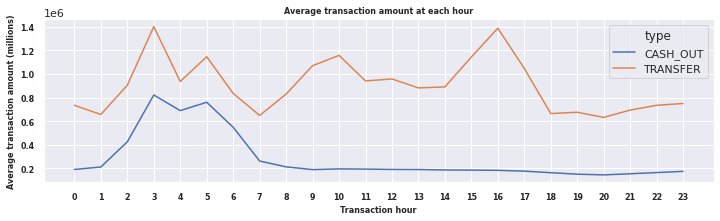

In [18]:
# avg. transaction amount at each hour for each transaction type
plt.figure(figsize=(12,3))
sns.lineplot(data=df.groupby(['transactionHour','type']).agg({'amount' : 'mean'}).round(2).reset_index(),
             x='transactionHour',
             y='amount',
             hue='type')
plt.xlabel('Transaction hour', fontsize=8, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=8, fontweight='bold', rotation=0)
plt.ylabel('Average transaction amount (millions)', fontsize=8, fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')
plt.title('Average transaction amount at each hour', fontsize=8, fontweight='bold')
plt.show()

The name (or ID) of the originator and destination are not needed for classification. So, 
we remove them.

In [20]:
df=df.drop(['nameOrig','nameDest'],axis=1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   step             int64  
 1   type             object 
 2   amount           float64
 3   oldbalanceOrg    float64
 4   newbalanceOrig   float64
 5   oldbalanceDest   float64
 6   newbalanceDest   float64
 7   isFraud          int64  
 8   isFlaggedFraud   int64  
 9   transactionHour  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 232.5+ MB


We have one categorical variable in the dataset – the transaction type. This feature needs 
to be encoded as binary variables

In [22]:
##HAndling categorical feature -type

df['type']=df['type'].map({'CASH_OUT':0,'TRANSFER':1})

df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transactionHour
2,1,1,181.00,181.0,0.0,0.0,0.00,1,0,1
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,0,1
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1


In [24]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transactionHour
2,1,1,181.00,181.0,0.0,0.0,0.00,1,0,1
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,0,1
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1


In [25]:
X = df.loc[:, df.columns != 'isFraud']
y  = df.loc[:, df.columns  == 'isFraud']

In [26]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,transactionHour
2,1,1,181.00,181.0,0.0,0.0,0.00,0,1
3,1,0,181.00,181.0,0.0,21182.0,0.00,0,1
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,1
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,1
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


In [27]:
y.head()

,isFraud
2,1
3,1
15,0
19,0
24,0


In [28]:
df['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [29]:
#Splitting the dataset fo Modelling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [30]:
#Scaling the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [31]:
#Machine Learning Models
models=[]
models.append(('lr',LogisticRegression()))
models.append(('decision tree',DecisionTreeClassifier()))

acc=[]
nam=[]

for name,model in models:
  kfold=KFold(n_splits=10) 
  cross_val_sc=cross_val_score(model,X_train,y_train,scoring='accuracy',cv=kfold)
  print('{} : accuracy:{}( standard deviation:{})'.format(name,cross_val_sc.mean(),cross_val_sc.std()))
  acc.append(cross_val_sc.mean()*100)
  nam.append(name)

lr : accuracy:0.998412325566283( standard deviation:8.31149967238167e-05)
decision tree : accuracy:0.9992770073840569( standard deviation:3.6124891678374585e-05)


From the above,it could be seen that the accuracy is around 99%. Due to highly imbalanced data, resulted into overfitting. Hence, resampling the data using SMOTE

In [38]:
#Re-Sampling the data
sm = SMOTE(random_state = 2)
x_train_res, y_train_res = sm.fit_resample(X_train, y_train)
  


In [40]:
#Re-training the Machine Learning Models
models=[]
models.append(('lr',LogisticRegression()))
models.append(('decision tree',DecisionTreeClassifier()))

acc=[]
nam=[]

for name,model in models:
  kfold=KFold(n_splits=10) 
  cross_val_sc=cross_val_score(model,x_train_res,y_train_res,scoring='accuracy',cv=kfold)
  print('{} : accuracy:{}( standard deviation:{})'.format(name,cross_val_sc.mean(),cross_val_sc.std()))
  acc.append(cross_val_sc.mean()*100)
  nam.append(name)

lr : accuracy:0.9441773145615343( standard deviation:0.004830006098838821)
decision tree : accuracy:0.9987842495352295( standard deviation:0.0004419144079746195)


It can be seen that Decision Tree is giving almost 99% accuracy. But, it might lead to overfitting. Hence, selecting Logistic Regression.

In [41]:
#Logistic Regression classifier
clf = LogisticRegression()
 
# Training the model on the training dataset
clf.fit(x_train_res, y_train_res)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.9489365425738459


In [44]:
confusion_matrix(y_test, y_pred)

array([[864919,  46569],
       [   115,   2632]])

#Values in the confusion matrix denotes:
* 864919: **True Positive:** Transactions which were fraud are predicted as fraud

* 46569: **False positive:** Transactions which were not fraud are predicted as fraud

* 115: **False negative:** Transactions which were fraud are predicted as not fraud

* 2632: **True negative:** Transactions which were not fraud and also predicted as not fraud 

#Ensemble Techniques

In [47]:
#Training the data using XGBoost Classifier for better performance of the model
xgb_model = XGBClassifier(gamma=0)
xgb_model.fit(x_train_res, y_train_res)

XGBClassifier()

In [48]:
from sklearn import metrics #Checking the model accuracy

xgb_pred = xgb_model.predict(X_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_test, xgb_pred)))

Accuracy Score = 0.9801331167588202


In [49]:
confusion_matrix(y_test, xgb_pred)

array([[893352,  18136],
       [    27,   2720]])

#Values in the confusion matrix denotes:
* 893352: **True Positive:** Transactions which were fraud are predicted as fraud

* 18136: **False positive:** Transactions which were not fraud are predicted as fraud

* 27: **False negative:** Transactions which were fraud are predicted as not fraud

* 2720: **True negative:** Transactions which were not fraud and also predicted as not fraud 

###Precision: Appropriate when minimizing false positives is the focus.
###Recall: Appropriate when minimizing false negatives is the focus.

For this model, we need to put more focus on false negatives in order to minimize fraud transactions. Hence,calculating Recall

In [51]:
# Finding recall
recall_score(y_test, xgb_pred)

0.9901710957408082